In [4]:
import glob
import os
import dna_features_viewer
import pandas as pd
from Bio import SeqIO
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord
import seaborn as sns
import gzip

In [27]:
class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        if feature.location.end == protein_end:
            return sns.color_palette('deep')[1]
        if feature.type == "CDS":
            return sns.color_palette("deep")[0]
        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[4]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]
    
    def compute_feature_label(self, feature):
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing

In [28]:
kmer_len = 25
gap_distance = 4

## WP_240297075.1 - a hypothetical protein annotated in NZ_CP092647 (E. Coli from Jinhua Central Hospital)

Clustered with 52 proteins found in other unique RefSeq genomes

### Original Protein Locus

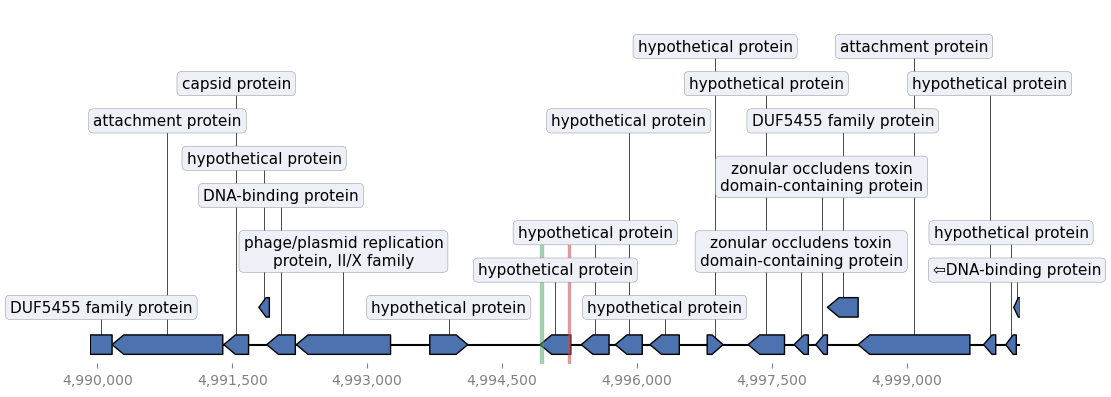

In [68]:
gbff = "/n/scratch3/users/a/ak586/refseq/bacteria/GCF_022453585.1/GCF_022453585.1_ASM2245358v1_genomic.gbff.gz"
protein_id = "WP_240297075.1"

found_record, protein_start, protein_end = None, None, None
window = 5000

with gzip.open(gbff, 'rt') as handle:
    for record in SeqIO.parse(handle, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                if "protein_id" in feature.qualifiers:
                    if protein_id in feature.qualifiers["protein_id"]:
                        found_record = record.id
                        protein_start = feature.location.start
                        protein_end = feature.location.end
                        protein_strand = '+'
                        if feature.location.strand == -1:
                            protein_start = feature.location.end
                            protein_end = feature.location.start
                            protein_strand = '-'
                        break

if protein_strand == "+":
    prefix_target_highlight_start = protein_start + gap_distance
    prefix_target_highlight_end = protein_start + gap_distance + kmer_len
    suffix_target_highlight_start = protein_end - gap_distance
    suffix_target_highlight_end = protein_end - gap_distance - kmer_len
    window_start = protein_start - window
    window_end = protein_end + window
else:
    prefix_target_highlight_start = protein_start - gap_distance
    prefix_target_highlight_end = protein_start - gap_distance - kmer_len
    suffix_target_highlight_start = protein_end + gap_distance
    suffix_target_highlight_end = protein_end + gap_distance + kmer_len
    window_start = protein_end - window
    window_end = protein_start + window

with gzip.open(gbff, 'rt') as handle:
    record = SeqIO.to_dict(SeqIO.parse(handle, format="genbank"))[found_record]
    record = MyCustomTranslator().translate_record(record)
    cropped_record = record.crop((window_start, window_end))
    ax, _ = cropped_record.plot(with_ruler=True, strand_in_label_threshold=7, figure_width=12)
    ax.fill_between((prefix_target_highlight_start, prefix_target_highlight_end),
                    +3, -1, alpha=0.45, color=sns.color_palette("deep")[3])
    ax.fill_between((suffix_target_highlight_start, suffix_target_highlight_end),
                +3, -1, alpha=0.45, color=sns.color_palette("deep")[2])

### FOUND K-MERS
Prefix and suffix k-mers found with a distance difference of ~8kb in 18 genomes, 3 bp apart in 1 genome, and 16kb apart in another genome

SAMN06015775 is one of the S. enterica strain w/ a distance difference of ~8kb 

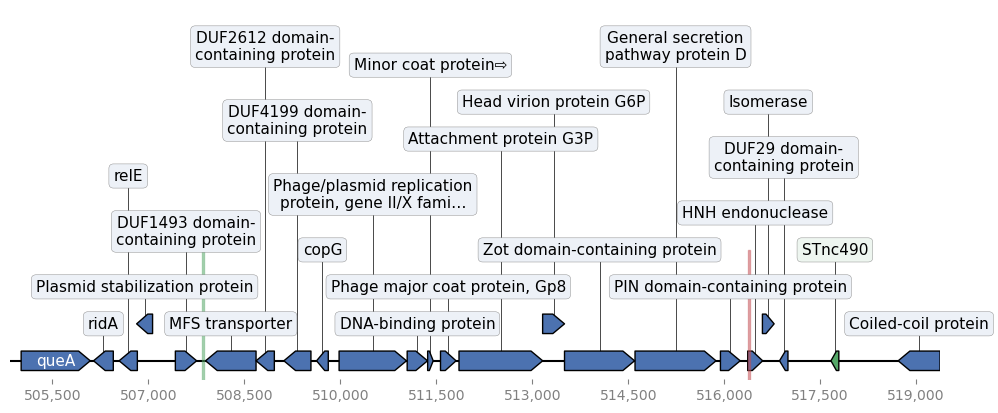

In [76]:
gbff = "/n/data1/hms/dbmi/baym/arya/data/miniphied-661k-gbks/SAMN05799441/SAMN05799441.gbff"
prefix_kmer_match = 516372
suffix_kmer_match = 507838
window = 3000

# if prefix_kmer_match > suffix_kmer_match:
#     prefix_kmer_match2 = suffix_kmer_match
#     suffix_kmer_match = prefix_kmer_match
#     prefix_kmer_match = prefix_kmer_match2

record = SeqIO.to_dict(SeqIO.parse(gbff, format="genbank"))['contig_1']
record = MyCustomTranslator().translate_record(record)
if prefix_kmer_match > suffix_kmer_match:
    cropped_record = record.crop((suffix_kmer_match - window, prefix_kmer_match + window))
else:
    cropped_record = record.crop((prefix_kmer_match - window, suffix_kmer_match + window))

prefix_target_highlight_start = prefix_kmer_match 
prefix_target_highlight_end = prefix_kmer_match + kmer_len
suffix_target_highlight_start = suffix_kmer_match 
suffix_target_highlight_end = suffix_kmer_match + kmer_len

ax, _ = cropped_record.plot(with_ruler=True, strand_in_label_threshold=7, figure_width=12)
ax.fill_between((prefix_target_highlight_start, prefix_target_highlight_end),
                +3, -1, alpha=0.45, color=sns.color_palette("deep")[3])
ax.fill_between((suffix_target_highlight_start, suffix_target_highlight_end),
            +3, -1, alpha=0.45, color=sns.color_palette("deep")[2])